## Using a pre-trained embedding from the TensorFlow Hub to categorise books

Final modelling scenario whereby I am utilzing a pre-trained embedding available from the TensorFlow Hub and code created by AIEngineering [online] available at https://www.youtube.com/watch?v=dkpS2g4K08s. This code csreate an end to end NLP pipeline starting from cleaning text data, setting NLP pipeline, model selection and model evaluation while handling handling imbalanced a dataset.

basic application of transfer learning with TensorFlow Hub and Keras.

## 1. Import required Python & TF packages

In [188]:
import pandas as pd
import numpy as np   
import datetime
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

## 2. TensorFlow environment

In [168]:
print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.6.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


## 3. Data preprocessing

In [169]:
#################### a. Import finalised data from CW1 ####################

# Keep the original unprocessed text and target (='Subject')
df=pd.read_csv(r"C:\Users\jmd05\DSM-020\4. CW1\Data\all1.csv", index_col=0, usecols=['Synopsis','Subject']).reset_index()
#df.shape #656, 2

In [170]:
#################### b. Create a dictionary comprising re-balancing weights for each target class ####################

class_weights=list(class_weight.compute_class_weight('balanced', np.unique(df['Subject']), df['Subject']))
class_weights.sort()
weights={}
for index, weight in enumerate(class_weights) :
    weights[index]=weight
weights

{0: 0.8913043478260869,
 1: 0.9010989010989011,
 2: 0.9213483146067416,
 3: 0.9318181818181818,
 4: 1.0379746835443038,
 5: 1.0933333333333333,
 6: 1.1388888888888888,
 7: 1.1714285714285715}

In [171]:
##################### c. Create the required subsets of data of model build and evaluations ####################

# This function was written by Stackoverflow user piRSquared at 
# https://stackoverflow.com/questions/38250710/how-to-split-data-into-3-sets-train-validation-and-test
# def train_validate_test_split(df, train_percent=.5, validate_percent=.25, seed=None):
#     np.random.seed(seed)
#     perm = np.random.permutation(df.index)
#     m = len(df.index)
#     train_end = int(train_percent * m)
#     validate_end = int(validate_percent * m) + train_end
#     train = df.iloc[perm[:train_end]]
#     validate = df.iloc[perm[train_end:validate_end]]
#     test = df.iloc[perm[validate_end:]]
#     return train, validate, test

# train_data, validation_data, test_data = train_validate_test_split(df)

# Decided dataset is too small for a hold out (the accuracy results were poor) so just use train and validation
train, valid = train_test_split(df, test_size=0.30, random_state=42)

In [39]:
#train.shape      # 459
#valid.shape      # 197

In [173]:
##################### d. Create Tensor slices #####################

train1 = tf.data.Dataset.from_tensor_slices((train['Synopsis'].values, train['Subject'].values))
valid1 = tf.data.Dataset.from_tensor_slices((valid['Synopsis'].values, valid['Subject'].values))
#test = tf.data.Dataset.from_tensor_slices((test_data['Synopsis'].values, test_data['Subject'].values))

In [174]:
# Review an example of tensor data - the synopses have not been processed in any way

train_example_synopsis, train_example_subject = next(iter(train1.batch(1)))
print(train_example_synopsis, train_example_subject)

tf.Tensor([b'for curious readers young and old a rich and colorful history of religion from humanity s earliest days to our own contentious times in an era of hardening religious attitudes and explosive religious violence this book offers a welcome antidote richard holloway retells the entire history of religion from the dawn of religious belief to the twenty first century with deepest respect and a keen commitment to accuracy writing for those with faith and those without and especially for young readers he encourages curiosity and tolerance accentuates nuance and mystery and calmly restores a sense of the value of faith ranging far beyond the major world religions of judaism islam christianity buddhism and hinduism holloway also examines where religious belief comes from the search for meaning throughout history today s fascinations with scientology and creationism religiously motivated violence hostilities between religious people and secularists and more holloway proves an empathic

In [175]:
##################### e. One hot encode the categorical target labels for NN processing #####################

# Note this section of code was adapted from that created by AIEngineering found online at 
# https://www.youtube.com/watch?v=dkpS2g4K08s

# Create a immutable look-up table that can be referred to in one hot encoding (OHE) process
table = tf.lookup.StaticHashTable(initializer=tf.lookup.KeyValueTensorInitializer(
                                  keys=tf.constant(['romantic fiction','history','sports leisure','food drink','entertainment',
                                                    'spirituality beliefs','science technology medicine',
                                                    'business finance law']), 
                                  values=tf.constant([0,1,2,3,4,5,6,7])),
                                  default_value=tf.constant(-1),
                                  name="target_encoding")

@tf.function
def target(x):
  return table.lookup(x)

# Define OHE function to transform the lable's 1-d representation to an 8-d array representation 
# (8 being the number of unique labels)
def fetch(text, labels):
  return text, tf.one_hot(target(labels),8)

# Undertake OHE on each element in the tensor slides
train2=train1.map(fetch)
valid2=valid1.map(fetch)
#test1=test.map(fetch)

In [176]:
# Review example of a transformed target label
next(iter(train2))

(<tf.Tensor: shape=(), dtype=string, numpy=b'for curious readers young and old a rich and colorful history of religion from humanity s earliest days to our own contentious times in an era of hardening religious attitudes and explosive religious violence this book offers a welcome antidote richard holloway retells the entire history of religion from the dawn of religious belief to the twenty first century with deepest respect and a keen commitment to accuracy writing for those with faith and those without and especially for young readers he encourages curiosity and tolerance accentuates nuance and mystery and calmly restores a sense of the value of faith ranging far beyond the major world religions of judaism islam christianity buddhism and hinduism holloway also examines where religious belief comes from the search for meaning throughout history today s fascinations with scientology and creationism religiously motivated violence hostilities between religious people and secularists and 

## 4. Model build

In [177]:
#################### a. Create a Keras layer that uses a TensorFlow Hub model to embed the sentences ####################

#embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
embedding = "https://tfhub.dev/google/nnlm-en-dim50-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                          dtype=tf.string, trainable=True)

#embedding = "https://tfhub.dev/google/nnlm-en-dim128/1"
# embedding = "https://tfhub.dev/google/nnlm-zh-dim128-with-normalization/2"
# hub_layer = hub.KerasLayer(embedding, output_shape=[128], input_shape=[], 
#                            dtype=tf.string, trainable=True)

# Review the embeddings for the example above
hub_layer(train_example_synopsis)

<tf.Tensor: shape=(1, 50), dtype=float32, numpy=
array([[ 0.15719491, -0.1995717 ,  0.24811843,  0.14680661, -0.4304029 ,
        -0.42705414, -0.81705767, -0.37310374, -0.84438545,  0.08288607,
        -0.10753941,  0.06627724, -0.06985325, -0.13207957,  0.20052053,
        -0.38404042, -0.24509044, -0.70608956,  0.31535238, -0.40940908,
        -0.00983365, -0.03260244,  1.3918756 , -0.01981452, -0.65770364,
         0.6233454 , -0.72337645, -0.26033735,  0.5417876 , -0.9557794 ,
        -0.13185675,  0.34277746,  0.44721085,  0.08461031, -1.093546  ,
        -0.20781052,  0.02075935,  0.08639432, -0.07590501, -1.1476374 ,
         0.59333414,  0.12367294, -0.5802365 ,  0.41011825,  0.09539206,
        -0.40901104,  0.37202957,  0.52231544,  0.4361763 , -0.0992899 ]],
      dtype=float32)>

In [178]:
#################### b. Build full model ####################

model = tf.keras.Sequential()
model.add(hub_layer)
#model.add(tf.keras.layers.Dense(64, activation='relu'))
#model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(8, activation='softmax'))

# Review model structure
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_2 (KerasLayer)   (None, 50)                48190600  
_________________________________________________________________
dense_4 (Dense)              (None, 16)                816       
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 136       
Total params: 48,191,552
Trainable params: 48,191,552
Non-trainable params: 0
_________________________________________________________________


In [179]:
#################### c. Compile the model ####################

# Set up Tensor board history
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="logs")

model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Set up Tensor board history
# log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [180]:
#################### d. Train the model #################### 

history = model.fit(train2.shuffle(197).batch(15),
                    epochs=10,
                    validation_data=valid2.batch(15),
                    verbose=1,
                    class_weight=weights,
                    callbacks=[tensorboard_callback])

# With extra layer of 128, 64, 8:

# 1. Using 50-d normalisation embedding get around 60% for validation accuracy using no weights, batch size=10 and no. of epochs=5
# 2. Using 128-d normalisation embedding get around 63% for validation accuracy using weights, batch size=10 and no. of epochs=5
# 3. Using 128-d normalisation embedding get 67.1% for test1 accuracy using weights, batch size=20 and no. of epochs=5
# 4. Using 128-d normalisation embedding get around 66% for validation accuracy using weights, batch size=30 and no. of epochs=5
# 5. Using 128-d normalisation embedding get 66.5% for test1 accuracy using weights, batch size=15 and no. of epochs=5
# 6. Using 128-d normalisation embedding get 66.5% for test1 accuracy using weights, batch size=20 and no. of epochs=10
# 7. Using 128-d normalisation embedding get 66.5% for test1 accuracy using weights, batch size=100 and no. of epochs=5

# With extra layer of 128, 64, 32, 8:
# 8. Using 128-d normalisation embedding get 66.5% for test1 accuracy using weights, batch size=100 and no. of epochs=5
# 9. Using 128-d normalisation embedding get 65.59% for test1 accuracy using weights, batch size=20 and no. of epochs=5

# Use the solution 3.

Epoch 1/10
31/31 [==============================] - 63s 2s/step - loss: 2.1039 - accuracy: 0.1634 - val_loss: 2.0762 - val_accuracy: 0.1472
Epoch 2/10
31/31 [==============================] - 36s 1s/step - loss: 1.8175 - accuracy: 0.4139 - val_loss: 1.9211 - val_accuracy: 0.2741
Epoch 3/10
31/31 [==============================] - 37s 1s/step - loss: 1.5456 - accuracy: 0.5621 - val_loss: 1.7757 - val_accuracy: 0.3350
Epoch 4/10
31/31 [==============================] - 36s 1s/step - loss: 1.2704 - accuracy: 0.7277 - val_loss: 1.6110 - val_accuracy: 0.4721
Epoch 5/10
31/31 [==============================] - 36s 1s/step - loss: 1.0048 - accuracy: 0.8867 - val_loss: 1.4819 - val_accuracy: 0.5533
Epoch 6/10
31/31 [==============================] - 36s 1s/step - loss: 0.7614 - accuracy: 0.9368 - val_loss: 1.3713 - val_accuracy: 0.5888
Epoch 7/10
31/31 [==============================] - 36s 1s/step - loss: 0.5535 - accuracy: 0.9695 - val_loss: 1.2754 - val_accuracy: 0.6244
Epoch 8/10
31/31 [==

In [181]:
#################### e. Tensorboard outputs #################### 

%load_ext tensorboard
#%reload_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 3416), started 3:20:55 ago. (Use '!kill 3416' to kill it.)

## 5. Model evaluation

In [182]:
#################### a. Overall accuracy and loss ####################

results=model.evaluate(valid2.batch(20), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

10/10 - 2s - loss: 1.1486 - accuracy: 0.6345
loss: 1.149
accuracy: 0.635


In [183]:
#################### b. Classification report ####################

# Get raw data & its target labels
validation_data, validation_labels = next(iter(valid2.batch(197)))
# Score with model
y_pred=model.predict(validation_data)
# Get overall performance measures
print(classification_report(validation_labels.numpy().argmax(axis=1), y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.72      0.88      0.79        24
           1       0.59      0.68      0.63        25
           2       0.96      0.59      0.73        37
           3       0.95      0.91      0.93        22
           4       0.67      0.50      0.57        32
           5       0.74      0.58      0.65        24
           6       0.24      0.57      0.34        14
           7       0.37      0.37      0.37        19

    accuracy                           0.63       197
   macro avg       0.65      0.64      0.63       197
weighted avg       0.70      0.63      0.65       197



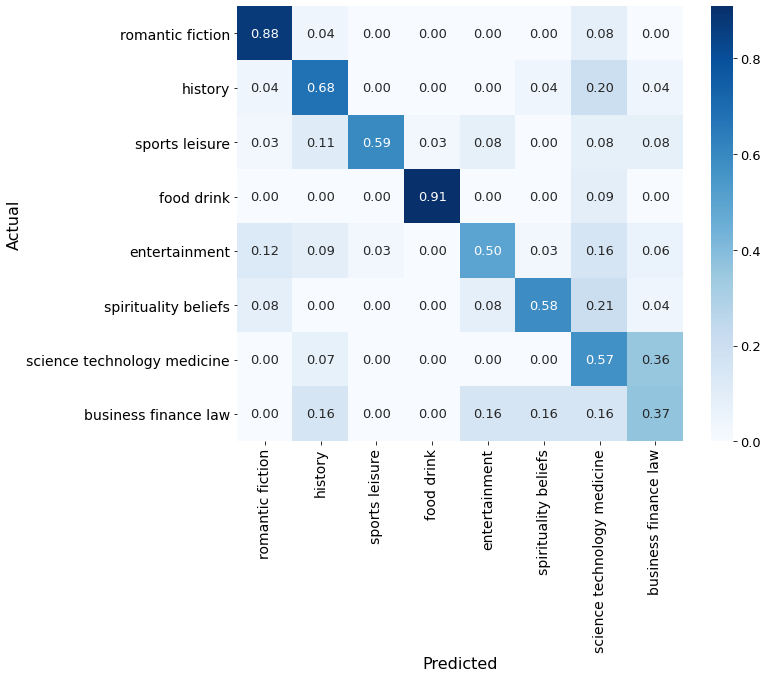

In [206]:
#################### c. Confusion matrix ####################

y_true = validation_labels.numpy().argmax(axis=1)
y_pred = y_pred#.argmax(axis=1)

labels = ['romantic fiction',
          'history',
          'sports leisure',
          'food drink',
          'entertainment',
          'spirituality beliefs',
          'science technology medicine',
          'business finance law']

cm = confusion_matrix(y_true, y_pred)
# Convert nominal values into percentages (of class)
cmp = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,8))
plt.rcParams.update({'font.size': 13})
sns.heatmap(cmp, annot=True, fmt='.2f', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.ylabel('Actual', size=16)
plt.xlabel('Predicted', size=16)
plt.show(block=False)

## Carpark

In [ ]:
#!pip install tensorboard
#!pip show tensorboard
#python C:\Users\jmd05\Anaconda3\Lib\site-packages\tensorboard\main.py --logdir=r'C:\Users\jmd05\Anaconda3\Lib\site-packages\tensorboard\logs\fit'

In [ ]:
# This automatically deletes the log directory

#import shutil
#shutil.rmtree('log_dir', ignore_errors=True)

In [ ]:
#valid['Subject'].value_counts(dropna=False)